In [1]:
import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec

import numpy as np
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

### Preparation of the spatial data

#### EDs polygon
The spatial data that we will use is given in the shapefile format. Firstly, we need to open it with geopandas and check its columns, display a sample of the dataset to get a better understanding of the data. Then we will investigate the Coordinate Reference System (CRS) of the file which is used to tell Python how those coordinates relate to places on the Earth.

In [2]:
eds = geopandas.read_file('cso_ed')

In [3]:
print(f'Coordinate system of the shapefile: {eds.crs}') # checking the georeference system
eds.columns

Coordinate system of the shapefile: epsg:4326


Index(['OBJECTID', 'ED_ID', 'ED_ENGLISH', 'ED_GAEILGE', 'COUNTY', 'CONTAE',
       'PROVINCE', 'CENTROID_X', 'CENTROID_Y', 'GUID_', 'CSOED_3409',
       'OSIED_3441', 'CSOED_34_1', 'Shape__Are', 'Shape__Len', 'area_km',
       'geometry'],
      dtype='object')

In [4]:
eds.head(2)

,OBJECTID,ED_ID,ED_ENGLISH,ED_GAEILGE,COUNTY,CONTAE,PROVINCE,CENTROID_X,CENTROID_Y,GUID_,CSOED_3409,OSIED_3441,CSOED_34_1,Shape__Are,Shape__Len,area_km,geometry
0,1,47033,BALLYMODAN,None,CORK,Corcaigh,Munster,547718.261772674,553339.455581436,2AE196291F5013A3E055000000000001,18013,47033,Ballymodan,2.837518e+07,31639.484213,28.375,"POLYGON ((-8.69709 51.73353, -8.69837 51.73341..."
1,2,97055,KILBEACON,Cill BhÃƒÂ©acÃƒÂ¡in,KILKENNY,Cill Chainnigh,Leinster,657681.211216703,627000.862373916,2AE19629240313A3E055000000000001,07103,97055,Kilbeacon,1.324602e+07,16740.823074,13.246,"POLYGON ((-7.12786 52.40372, -7.12056 52.40202..."


#### CRS
WGS84 Latitude/Longitude: "EPSG:4326" is the coordinate system of the shapefile. We also see that the CENTROID_X and CENTROID_Y fields store the coordinates of the polygon centroids in the EPSG:2157 - IRENET95 / Irish Transverse Mercator ( the projected coordinate used in Ireland). <br><br>
Later on, when we will create a new geodataframe representing centroids of the electoral divisions, we will re-project the coordinates to WGS84 to keep consistency in our datasets.


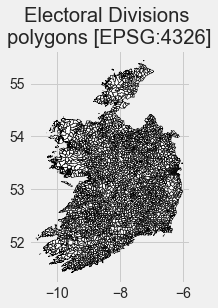

In [5]:
# displaying boundries of the Electoral Divisions
ax = eds.plot(color='white', edgecolor='black')
plt.title('Electoral Divisions \npolygons [EPSG:4326]')
plt.show()

In [6]:
# creating pandas dataframe for centroids
df = pd.DataFrame({
    'ED_ID': eds['ED_ID'],
    'Latitude': eds['CENTROID_Y'],
    'Longitude': eds['CENTROID_X'],
    })

# converting dataframe to geodataframe
points = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude)).set_crs("EPSG:2157")

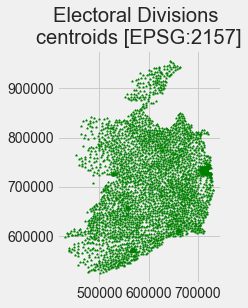

In [7]:
points.plot(marker='*', color='green', markersize=5)
plt.title('Electoral Divisions \ncentroids [EPSG:2157]')
plt.show()

**Re-projecting** coordinates of the centroids to WGS84 Latitude/Longitude.

In [8]:
points = points.to_crs('EPSG:4326') 
print(f'Coordinate system of the centroids: {points.crs}') 

Coordinate system of the centroids: EPSG:4326


Now we can remove the redundant fields from the 'eds' dataframe and add centroids coordinates from the 'points' geodataframe. So we will have two geometry types in one geopandas dataframe with the same CRS.

In [9]:
# droping redundant columns
to_be_removed = ['Shape__Are','Shape__Len','CSOED_34_1','OSIED_3441','CSOED_3409','CENTROID_Y','CENTROID_X','CONTAE','ED_GAEILGE','OBJECTID']
eds.drop(to_be_removed, axis=1, inplace=True)

In [10]:
# copying lat and long 
eds['LON'] = points['geometry'].x
eds['LAT'] = points['geometry'].y

In [11]:
eds.head(1)

,ED_ID,ED_ENGLISH,COUNTY,PROVINCE,GUID_,area_km,geometry,LON,LAT
0,47033,BALLYMODAN,CORK,Munster,2AE196291F5013A3E055000000000001,28.375,"POLYGON ((-8.69709 51.73353, -8.69837 51.73341...",-8.756855,51.72997


### Census data from 2016 for Electoral Divisions

The data is can be found on the official website of Irish [Central Statistics Office](https://www.cso.ie/) and it can be downlinked from this web page [link](https://www.cso.ie/en/census/census2016reports/census2016smallareapopulationstatistics/)


In [12]:
dataset2016 = pd.read_csv('SAPS2016_ED3409.csv', encoding= 'unicode_escape')
dataset2016.shape

C:\Users\Ukasz\Anaconda3\envs\geopandas\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (23,24,25,26,27,28,58,59,60,61,62,63,93,94,97,98,99,100,101,128,130,135,136,137,138,144,145,146,147,150,156,157,159,165,166,172,174,181,182,185,192,193,201,204,208,209,210,217,220,222,223,225,226,230,231,236,241,242,243,244,245,249,250,251,256,262,263,265,273,274,275,277,282,285,288,289,290,291,292,294,295,296,304,305,306,307,310,315,328,332,335,337,341,342,343,353,354,355,358,364,373,374,375,378,380,381,382,383,391,394,405,409,410,412,413,414,418,425,429,430,454,458,461,462,464,470,471,472,473,479,481,486,488,489,490,494,497,498,502,507,510,511,512,513,514,522,523,526,527,528,529,538,541,548,556,557,558,559,564,565,566,567,569,573,575,585,589,597,598,599,601,602,608,609,610,614,615,621,622,623,626,627,628,633,634,636,637,638,639,640,641,643,645,647,648,657,659,671,672,679,681,682,683,684,687,688,689,693,694,695,697,699,700,704,712,722,727,728,730,733,734,735,738,740,7

(3409, 802)

Those two fields contain information about poles living in Ireland in the dataset:
- T2_1PLN -- Poland - Nationality
- T2_1PLBP -- Poland - Birthplace

We gonna use only the T2_1PLN data when referring to statistics about the polish population in Ireland.
<br> 
A glossary of table variables is available here SAPS 2016 Glossary [XLS](https://www.cso.ie/en/media/csoie/census/census2016/census2016boundaryfiles/SAPS_2016_Glossary.xlsx)

## Exploring administration units of Ireland and some basic statistics

Let's start by adding the population information to the spatial dataset.
<br><br>
This needs to be done based on the common field:
- GUID_ in the spatial dataset
- GUID in the tabular data

In [13]:
# renaming GUID_ to GUID
eds = eds.rename(columns={'GUID_': 'GUID'})

In [14]:
# merging dataframes
data  = eds.merge(dataset2016, on='GUID', how='left')
data[['GUID', 'ED_ENGLISH','GEOGDESC']].head(2)

,GUID,ED_ENGLISH,GEOGDESC
0,2AE196291F5013A3E055000000000001,BALLYMODAN,Ballymodan
1,2AE19629240313A3E055000000000001,KILBEACON,Kilbeacon


### Whole country

#### Nationalities 

These are the fiedlds that contain information about nationalities in the census data:
- T2_1PLN -- Poland - Nationality
- T2_1PLBP -- Poland - Birthplace
- T1_1AGETT -- Total Population 
- T2_1IEN -- Ireland - Nationality
- T2_1UKN -- UK - Nationality
- T2_1LTN -- Lithuania - Nationality
- T2_1EUN -- Other EU28 - Nationality
- T2_1RWN -- Rest of world - Nationality
- T2_1NSN -- Not stated - Nationality

In [15]:
codes = ['T2_1IEN','T2_1PLN','T2_1UKN','T2_1LTN','T2_1EUN','T2_1RWN','T2_1NSN','T1_1AGETT']
nationalities = ['Ireland','Poland','UK','Lithuania','Other EU28','Rest of world ','Not stated','Total Population']

In [16]:
new_naming = dict(zip(codes, nationalities))

# renaming the columns
data = data.rename(columns=new_naming)
data[nationalities].head(1)

,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population
0,"3,784",247,91,41,193,37,56,"4,489"


We need to convert string data to numerical before proceeding with the statistics and set missing values to 0

In [17]:
data[nationalities].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3409 entries, 0 to 3408
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Ireland           3409 non-null   object
 1   Poland            3409 non-null   object
 2   UK                3409 non-null   int64 
 3   Lithuania         3409 non-null   object
 4   Other EU28        3409 non-null   object
 5   Rest of world     3409 non-null   object
 6   Not stated        3409 non-null   int64 
 7   Total Population  3409 non-null   object
dtypes: int64(2), object(6)
memory usage: 239.7+ KB


In [18]:
# convertig object data type to integer
string_data = ['Ireland','Poland','Lithuania','Other EU28','Rest of world ','Total Population']

In [19]:
for field in string_data:
    data[field].fillna('0', inplace=True)
    data[field] = data[field].astype(str).str.strip()  
    data[field] = data[field].astype(str).str.replace(',','')
    data[field] = data[field].astype(int)

In [20]:
data[nationalities].describe()

,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population
count,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000
mean,1197.569082,35.938692,30.247287,10.722206,43.044295,37.124377,21.100909,1396.850983
std,1920.733320,112.364744,41.339118,43.900141,123.049310,110.223106,55.538347,2329.295341
min,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000
25%,321.000000,0.000000,9.000000,0.000000,2.000000,1.000000,2.000000,349.000000
50%,577.000000,3.000000,18.000000,0.000000,6.000000,4.000000,5.000000,630.000000
75%,1260.000000,16.000000,34.000000,4.000000,22.000000,16.000000,15.000000,1443.000000
max,30194.000000,1590.000000,442.000000,1013.000000,3093.000000,1766.000000,875.000000,38894.000000


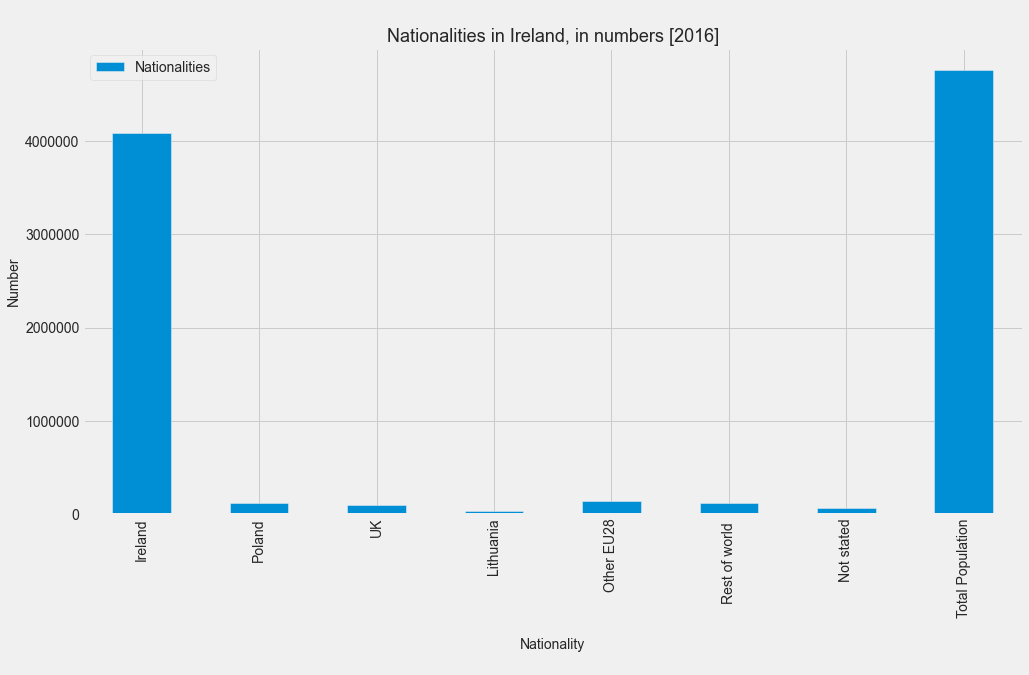

In [21]:
df = pd.DataFrame({'Nationalities': [data[field].sum() for field in nationalities]}, index=nationalities)
 
df.plot(kind="bar", figsize=(15,8))
plt.ticklabel_format(axis='y', style='plain')
plt.title('\nNationalities in Ireland, in numbers [2016]', fontsize=18)
plt.xlabel('\nNationality\n', fontsize=14)
plt.ylabel('Number', fontsize=14)

plt.savefig('Nationalities_in_Ireland_bar')

plt.show()

df['Percentage'] = ((df['Nationalities']/data['Total Population'].sum()) * 100).round(2)


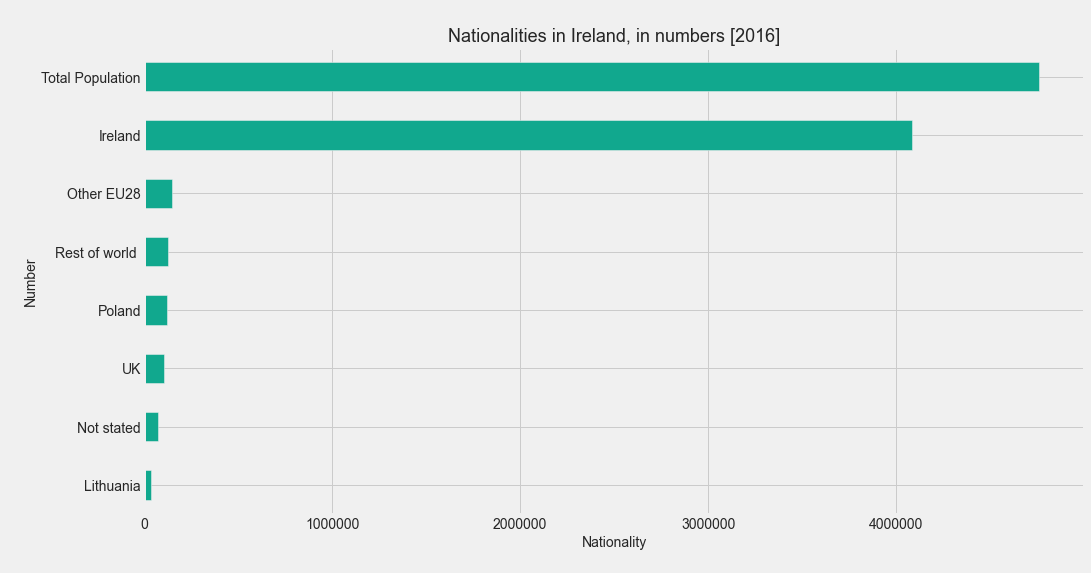

,Lithuania,Not stated,UK,Poland,Rest of world,Other EU28,Ireland,Total Population
Nationalities,36552,71933,103113,122515,126557,146738,4082513,4761865
Percentage,0.77,1.51,2.17,2.57,2.66,3.08,85.73,100.0
Nationality,Lithuania,Not stated,UK,Poland,Rest of world,Other EU28,Ireland,Total Population


In [22]:
df['Nationality'] = df.index
df = df.sort_values(by=['Nationalities'], ascending=True)


df.plot.barh(x='Nationality', y='Nationalities',
             title='Cuisine Preference', color='#11a88e', legend=False, figsize=(15,8))

plt.ticklabel_format(axis='x', style='plain')
plt.title('\nNationalities in Ireland, in numbers [2016]', fontsize=18)
plt.xlabel('Nationality\n', fontsize=14)
plt.ylabel('\nNumber', fontsize=14)

plt.savefig('Nationalities_in_Ireland_bar.png', dpi=300, bbox_inches='tight')
plt.show()


df.T

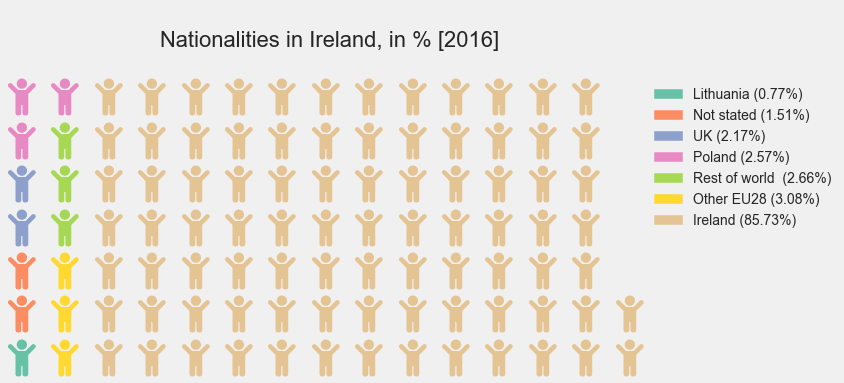

In [23]:
from pywaffle import Waffle

values = df.to_dict('dict')['Percentage']
values.popitem()


fig = plt.figure(FigureClass=Waffle, figsize=(12,7), values=  values, columns=15, 
                 block_arranging_style='snake',
                 icons='child',
                 labels=["{0} ({1}%)".format(k, v) for k, v in values.items()],
                 legend={'bbox_to_anchor': (1.3, 1), 'fontsize':14, 'frameon': False})
                 

plt.title('\nNationalities in Ireland, in % [2016]\n', fontsize=22)

plt.savefig('Nationalities_in_Ireland_pre', dpi=300, bbox_inches='tight')

plt.show()

### Provinces

In [24]:
province_names = list(data['PROVINCE'].unique())
province_names

['Munster', 'Leinster', 'Connacht', 'Ulster']

**Area** & **Population**

In [25]:
# setting a color palet for provinces
colors_palet = {"Connacht": "#66c2a5", "Leinster": "#fc8d62", "Munster": "#8da0cb", "Ulster": "#e78ac3"}
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# generating a custom cmap
cmap = matplotlib.colors.ListedColormap(colors)

In [26]:
areas = data.groupby('PROVINCE')['area_km'].sum().reset_index(name='SQ Kilometers')
areas['SQ Kilometers'] = areas['SQ Kilometers'].astype(int)
areas['PercentageAREA'] = ((areas['SQ Kilometers'] / areas['SQ Kilometers'].sum())* 100).round(2)

In [27]:
population = data.groupby('PROVINCE')['Total Population'].sum().reset_index(name='Population')
population['PopulationMLN'] = (population['Population']/1000000).round(2)
population['PercentagePOP'] = ((population['Population'] / population['Population'].sum())* 100).round(2)

In [28]:
population_density = pd.concat([areas, population], axis=1)
population_density['Density'] = (population_density['Population'] / population_density['SQ Kilometers']).astype(int)
population_density = population_density.loc[:,~population_density.columns.duplicated()] # remove dupicates in columns 
population_density

,PROVINCE,SQ Kilometers,PercentageAREA,Population,PopulationMLN,PercentagePOP,Density
0,Connacht,17706,25.20,550688,0.55,11.56,31
1,Leinster,19800,28.18,2634403,2.63,55.32,133
2,Munster,24669,35.11,1280020,1.28,26.88,51
3,Ulster,8085,11.51,296754,0.30,6.23,36


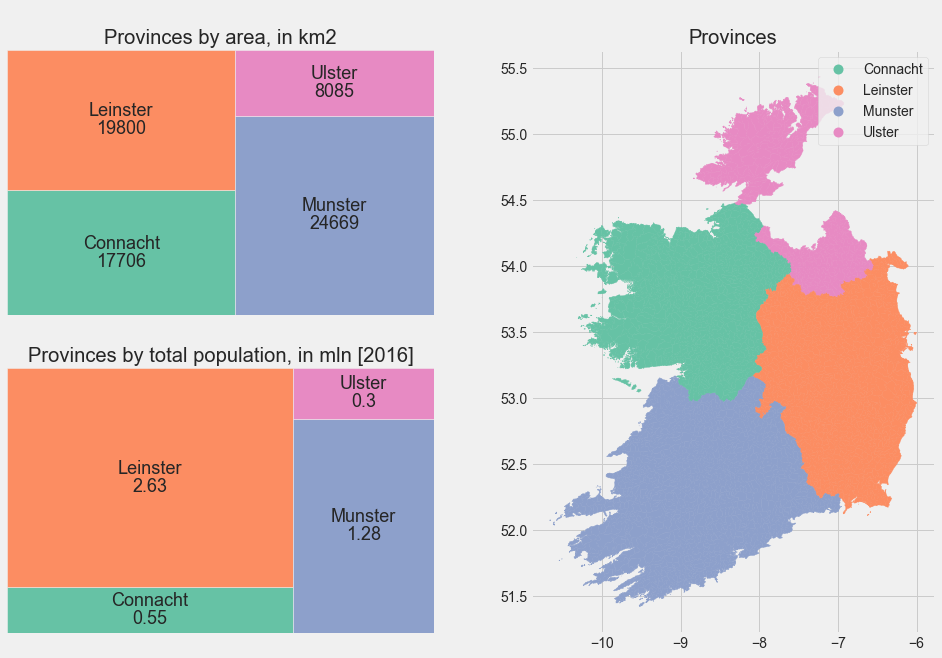

In [29]:
import squarify

# GRID GUIDANCE DOCUMENTATION
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html
fontsize = 18

fig = plt.figure(figsize=(15, 10))

gs = fig.add_gridspec(2,2)

ax1 = fig.add_subplot(gs[:, 1])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0])

eds.plot(column='PROVINCE', edgecolor="face", linewidth=0.4, legend=True, cmap=cmap, ax=ax1)
squarify.plot(sizes=areas['SQ Kilometers'], label=areas['PROVINCE'], value=areas['SQ Kilometers'], color=colors, text_kwargs={'fontsize': fontsize}, ax=ax2).axis('off')
squarify.plot(sizes=population['PopulationMLN'], label=population['PROVINCE'], value=population['PopulationMLN'], color=colors, text_kwargs={'fontsize': fontsize}, ax=ax3).axis('off')

ax1.title.set_text('Provinces')
ax2.title.set_text('\nProvinces by area, in km2')
ax3.title.set_text('\nProvinces by total population, in mln [2016]')

plt.savefig('square_Area_Population_1')

plt.show()

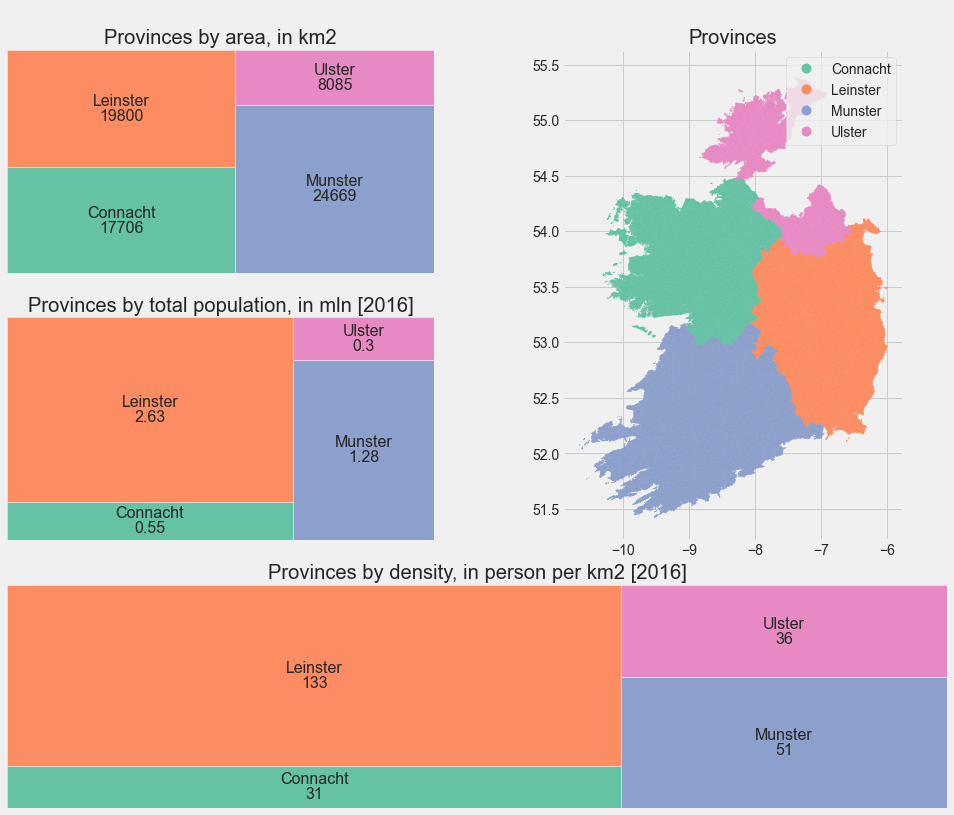

In [30]:
import squarify

# GRID GUIDANCE DOCUMENTATION
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html
fontsize = 16

fig = plt.figure(figsize=(15, 13))

gs = fig.add_gridspec(3,2)

ax1 = fig.add_subplot(gs[0:2, 1])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[2, :])

eds.plot(column='PROVINCE', edgecolor="face", linewidth=0.4, legend=True, cmap=cmap, ax=ax1)
squarify.plot(sizes=areas['SQ Kilometers'], label=areas['PROVINCE'], value=areas['SQ Kilometers'], color=colors, text_kwargs={'fontsize': fontsize}, ax=ax2).axis('off')
squarify.plot(sizes=population['PopulationMLN'], label=population['PROVINCE'], value=population['PopulationMLN'], color=colors, text_kwargs={'fontsize': fontsize}, ax=ax3).axis('off')
squarify.plot(sizes=population_density['Density'], label=population_density['PROVINCE'], value=population_density['Density'], color=colors,text_kwargs={'fontsize': fontsize}, ax=ax4).axis('off')

ax1.title.set_text('Provinces')
ax2.title.set_text('\nProvinces by area, in km2')
ax3.title.set_text('\nProvinces by total population, in mln [2016]')
ax4.title.set_text('\nProvinces by density, in person per km2 [2016]')

plt.savefig('square_Area_Population_2')

plt.show()

**Nationalities** in **Provinces**

In [31]:
df = data[['PROVINCE'] + nationalities]

In [32]:
df = df.groupby(['PROVINCE'])[nationalities].sum()
# df = df.groupby(['PROVINCE'])[nationalities].sum().reset_index()

# creating percentage fields for each nationality
for nationality in nationalities[:-1]: 
    df[f'{nationality}%'] = ((df[nationality]/df[nationalities[-1]]) * 100).round(2)
    
# list holding names of percentage fields that we created above
nationalities_pre = [x +'%' for x in nationalities[:-1]]

In [33]:
df[nationalities]

,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population
PROVINCE,,,,,,,,
Connacht,477194,14030,17281,3116,12019,11092,6767,550688
Leinster,2228538,67883,45253,22802,99434,86130,44717,2634403
Munster,1115176,35419,31690,6356,30640,25277,16890,1280020
Ulster,261605,5183,8889,4278,4645,4058,3559,296754


In [34]:
df[nationalities_pre]

,Ireland%,Poland%,UK%,Lithuania%,Other EU28%,Rest of world %,Not stated%
PROVINCE,,,,,,,
Connacht,86.65,2.55,3.14,0.57,2.18,2.01,1.23
Leinster,84.59,2.58,1.72,0.87,3.77,3.27,1.70
Munster,87.12,2.77,2.48,0.50,2.39,1.97,1.32
Ulster,88.16,1.75,3.00,1.44,1.57,1.37,1.20


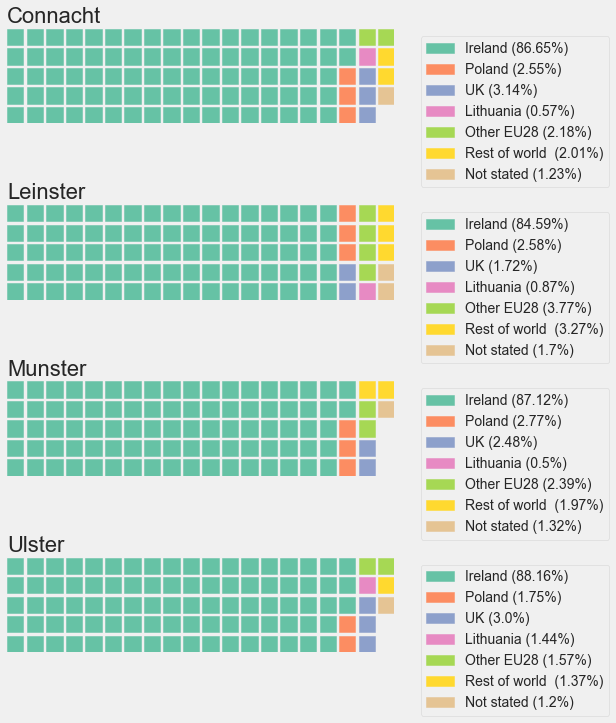

In [35]:
pre_df = df[nationalities_pre].T

fontsize = 14
title_size = 22

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '411': {
            'values': pre_df['Connacht'],
            'labels': [f'{k[:-1]} ({v}%)' for k, v in pre_df.to_dict()['Connacht'].items()],
            'block_arranging_style':'snake',
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': fontsize},
            'title': {'label': 'Connacht', 'loc': 'left', 'fontsize': title_size}
        },
        '412': {
            'values': pre_df['Leinster'],
            'labels': [f'{k[:-1]} ({v}%)' for k, v in pre_df.to_dict()['Leinster'].items()],
            'block_arranging_style':'snake',
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': fontsize},
            'title': {'label': 'Leinster', 'loc': 'left', 'fontsize': title_size}
        },
        '413': {
            'values': pre_df['Munster'],
            'labels': [f'{k[:-1]} ({v}%)' for k, v in pre_df.to_dict()['Munster'].items()],
            'block_arranging_style':'snake',
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': fontsize},
            'title': {'label': 'Munster', 'loc': 'left', 'fontsize': title_size}
        },
        '414': {
            'values': pre_df['Ulster'],
            'labels': [f'{k[:-1]} ({v}%)' for k, v in pre_df.to_dict()['Ulster'].items()],
            'block_arranging_style':'snake',
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': fontsize},
            'title': {'label': 'Ulster', 'loc': 'left', 'fontsize': title_size}
        },
    },
    columns=20,
    figsize=(20, 10)
)

fig.savefig('Waffle_Foreigners_per_Province_pre', dpi=300, bbox_inches='tight')

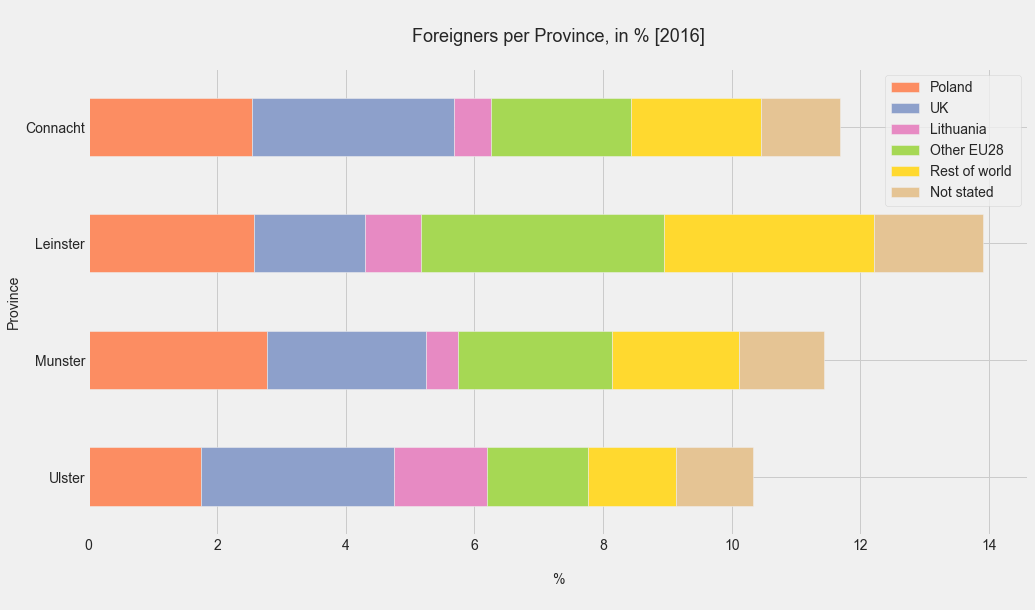

In [36]:
colors_nationalities = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
pre = df[nationalities_pre]
pre = pre.sort_index(ascending=False)
pre.columns = [n[:-1] for n in list(pre.columns)]

pre[['Poland', 'UK', 'Lithuania', 'Other EU28', 'Rest of world ','Not stated']].plot.barh(rot=0, figsize=(15,8), stacked= True, color=colors_nationalities[1:])
plt.title('\nForeigners per Province, in % [2016]\n', fontsize=18)
plt.xlabel('\n%\n', fontsize=14)
plt.ylabel('Province', fontsize=14)

plt.savefig('Foreigners_per_Province_pre', dpi=300, bbox_inches='tight')

plt.show()

**Poles** number in **Provinces**

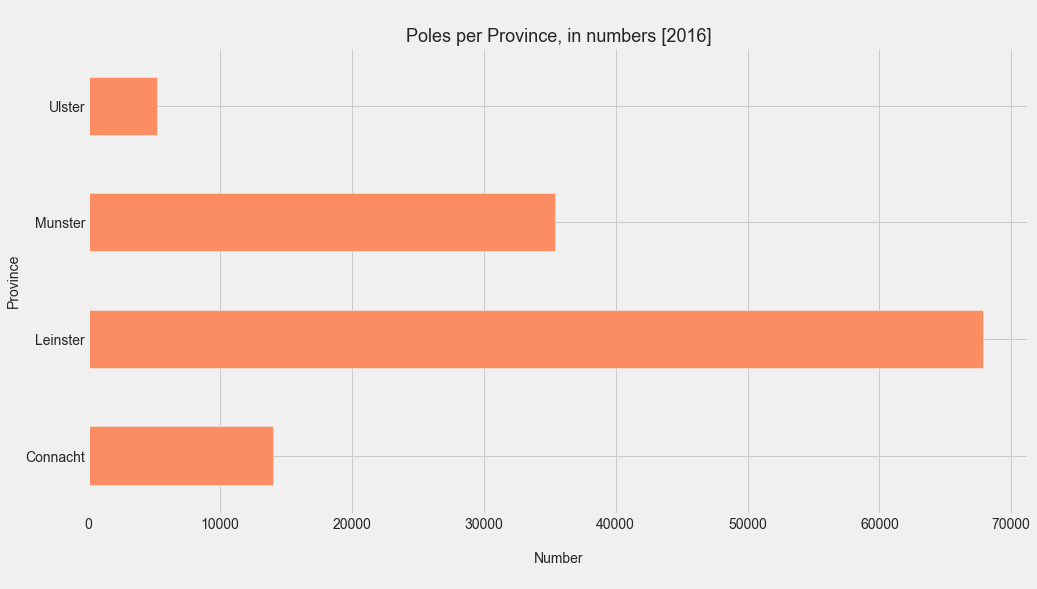

In [37]:
pre = df[nationalities]
pre[['Poland']].plot.barh(rot=0, figsize=(15,8), stacked= True, color='#fc8d62', legend=False)
plt.title('\nPoles per Province, in numbers [2016]', fontsize=18)
plt.xlabel('\nNumber\n', fontsize=14)
plt.ylabel('Province', fontsize=14)

plt.savefig('Poles_per_Province', dpi=300, bbox_inches='tight')

plt.show()

**Foreigners** number in **Provinces**

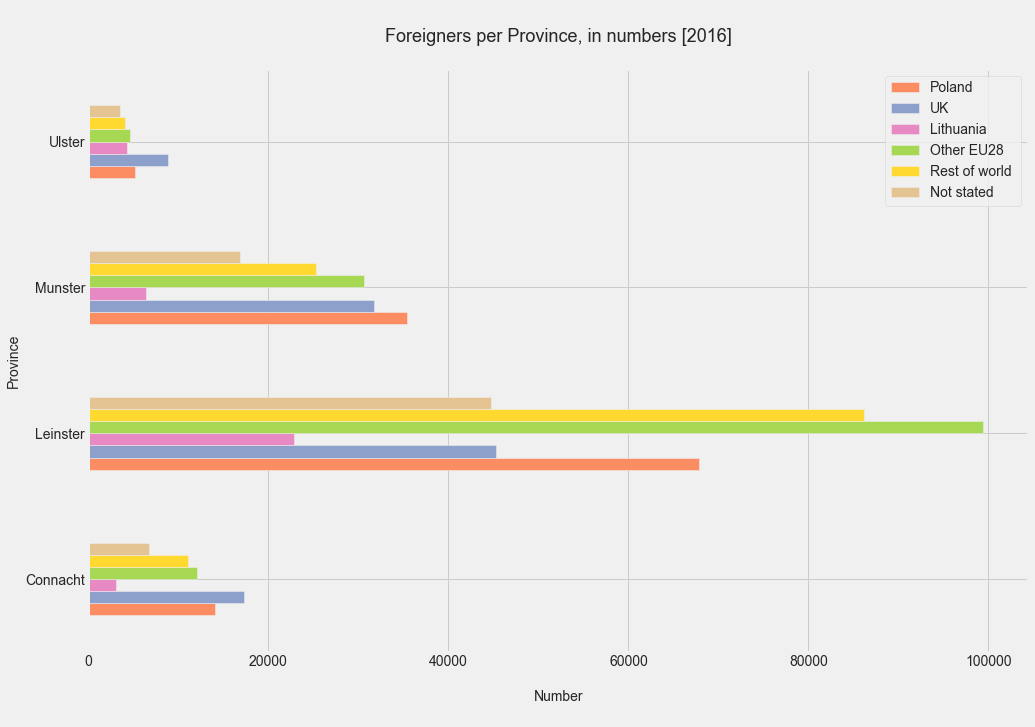

In [38]:
colors_nationalities = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
pre = df[nationalities]
pre[['Poland', 'UK', 'Lithuania', 'Other EU28', 'Rest of world ','Not stated']].plot.barh(rot=0, figsize=(15,10), color=colors_nationalities[1:])
plt.title('\nForeigners per Province, in numbers [2016]\n', fontsize=18)
plt.xlabel('\nNumber\n', fontsize=14)
plt.ylabel('Province', fontsize=14)

plt.savefig('Minority_groups_provinces', dpi=300, bbox_inches='tight')

plt.show()

### Counties

In [39]:
data['COUNTY'] = data['COUNTY'].str.title() # Converts first character of each word to uppercase and remaining to lowercase.
county_names = list(data['COUNTY'].unique())
print(county_names)

['Cork', 'Kilkenny', 'Limerick', 'Tipperary', 'Westmeath', 'Laois', 'Galway', 'Dublin', 'Roscommon', 'Clare', 'Leitrim', 'Waterford', 'Donegal', 'Kerry', 'Offaly', 'Carlow', 'Wexford', 'Meath', 'Longford', 'Monaghan', 'Cavan', 'Mayo', 'Louth', 'Sligo', 'Kildare', 'Wicklow']


**Area** & **Population** of Counties

In [40]:
areas = data.groupby('COUNTY')['area_km'].sum().reset_index(name='SQ Kilometers')
areas['SQ Kilometers'] = areas['SQ Kilometers'].astype(int)
areas['PercentageAREA'] = ((areas['SQ Kilometers'] / areas['SQ Kilometers'].sum())* 100).round(2)
areas.head(2)

,COUNTY,SQ Kilometers,PercentageAREA
0,Carlow,896,1.28
1,Cavan,1931,2.75


In [41]:
population = data.groupby('COUNTY')['Total Population'].sum().reset_index(name='Population')
population['PopulationMLN'] = (population['Population']/1000000).round(3)
population['PercentagePOP'] = ((population['Population'] / population['Population'].sum())* 100).round(2)
population.head(2)

,COUNTY,Population,PopulationMLN,PercentagePOP
0,Carlow,56932,0.057,1.2
1,Cavan,76176,0.076,1.6


In [42]:
population_density = pd.concat([areas, population], axis=1)
population_density['Density'] = (population_density['Population'] / population_density['SQ Kilometers']).astype(int)
population_density = population_density.loc[:,~population_density.columns.duplicated()] # remove dupicates in columns 
population_density

,COUNTY,SQ Kilometers,PercentageAREA,Population,PopulationMLN,PercentagePOP,Density
0,Carlow,896,1.28,56932,0.057,1.20,63
1,Cavan,1931,2.75,76176,0.076,1.60,39
2,Clare,3448,4.91,118817,0.119,2.50,34
3,Cork,7500,10.68,542868,0.543,11.40,72
4,Donegal,4860,6.92,159192,0.159,3.34,32
5,Dublin,925,1.32,1347359,1.347,28.29,1456
6,Galway,6148,8.75,258058,0.258,5.42,41
7,Kerry,4804,6.84,147707,0.148,3.10,30
8,Kildare,1694,2.41,222504,0.223,4.67,131
9,Kilkenny,2071,2.95,99232,0.099,2.08,47


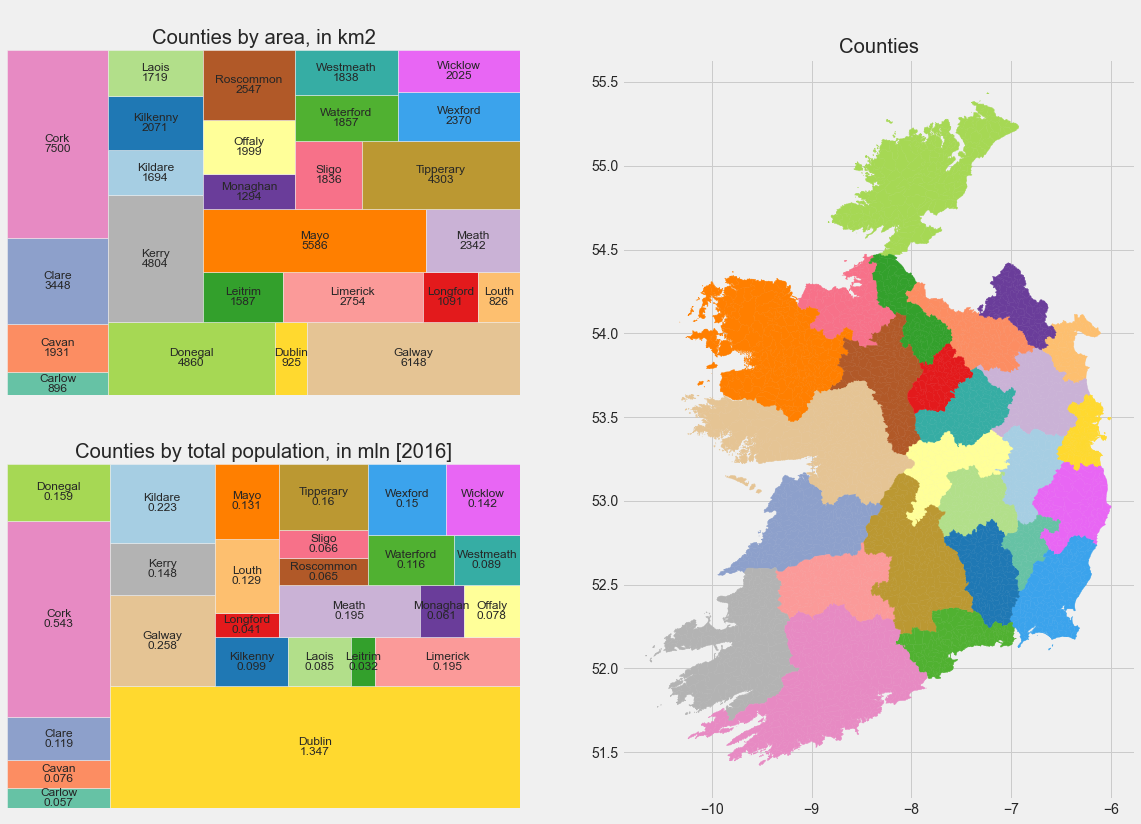

In [43]:
import squarify

# GRID GUIDANCE DOCUMENTATION
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_multicolumn.html
fontsize = 12

# generating unique 26 unique colors seaborn Qualitative color palettes
colors = sns.color_palette("Set2", 8) + sns.color_palette("Paired", 12) + sns.color_palette("husl", 6)
# creating cmap for the geopandas map
cmap = matplotlib.colors.ListedColormap(colors)

fig = plt.figure(figsize=(18, 13))

gs = fig.add_gridspec(2,2)

ax1 = fig.add_subplot(gs[:, 1])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0])

eds.plot(column='COUNTY', edgecolor="face", cmap=cmap, linewidth=0.4, ax=ax1)
squarify.plot(sizes=areas['SQ Kilometers'], label=areas['COUNTY'], value=areas['SQ Kilometers'], color=colors, text_kwargs={'fontsize': fontsize}, ax=ax2).axis('off')
squarify.plot(sizes=population['PopulationMLN'], label=population['COUNTY'], value=population['PopulationMLN'], color=colors, text_kwargs={'fontsize': fontsize}, ax=ax3).axis('off')

ax1.title.set_text('Counties')
ax2.title.set_text('\nCounties by area, in km2')
ax3.title.set_text('\nCounties by total population, in mln [2016]')

plt.savefig('Area_Population_Counties', dpi=300, bbox_inches='tight')

plt.show()

In [44]:
df = population_density.copy()
df.index = df['COUNTY'].str.title()
df = df[['Density']]

In [45]:
density_county = df.to_dict('dict')['Density']
def populate_county_density(row):
    return density_county[row['COUNTY']]
data['Density_County'] = data.apply(populate_county_density, axis=1)

In [46]:
# with---> mapclassify type 
# https://geopandas.org/en/stable/docs/user_guide/mapping.html
# https://geopandas.org/en/stable/gallery/choropleths.html

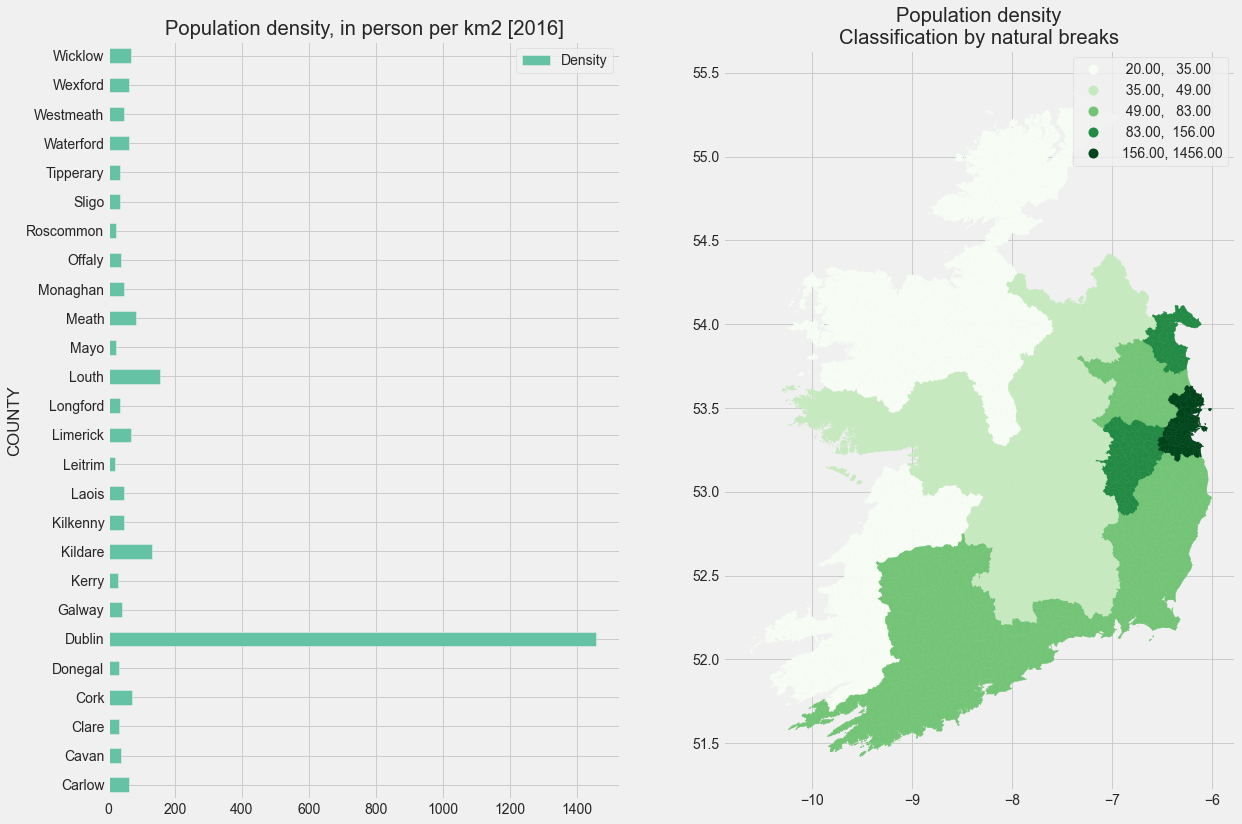

In [47]:
fig = plt.figure(figsize=(18, 13))

gs = fig.add_gridspec(2,2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

df.plot.barh(color=colors,ax=ax1)
data.plot(column='Density_County', edgecolor="face", linewidth=0.4, ax=ax2, legend=True, cmap='Greens', scheme='natural_breaks')

ax1.title.set_text('Population density, in person per km2 [2016]')
ax2.title.set_text('Population density\nClassification by natural breaks')

plt.savefig('Population_density_county', dpi=300, bbox_inches='tight')

plt.show()

**Nationalities** in **Counties**

In [48]:
df = data[['COUNTY'] + nationalities]

In [49]:
df = df.groupby(['COUNTY'])[nationalities].sum()

# creating percentage fields for each nationality
for nationality in nationalities[:-1]: 
    df[f'{nationality}%'] = ((df[nationality]/df[nationalities[-1]]) * 100).round(2)
    
# list holding names of percentage fields that we created above
nationalities_pre = [x +'%' for x in nationalities[:-1]]

In [50]:
df[['Ireland', 'Poland', 'UK', 'Lithuania', 'Other EU28', 'Rest of world ', 'Not stated', 'Total Population']]

,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population
COUNTY,,,,,,,,
Carlow,49654,2277,1107,239,1438,871,890,56932
Cavan,65609,2189,2041,1433,1755,1396,897,76176
Clare,103829,2844,3127,362,2435,2302,1561,118817
Cork,470576,16292,12630,2720,16124,11267,6236,542868
Donegal,142681,2012,5853,345,1435,1832,2011,159192
Dublin,1094986,33743,19282,9857,68109,63118,30007,1347359
Galway,220690,7507,6103,1390,6923,6736,3557,258058
Kerry,125642,4237,4947,891,3033,2316,2454,147707
Kildare,195081,7199,3789,1693,5727,4889,2138,222504


In [51]:
df[['Ireland%', 'Poland%', 'UK%', 'Lithuania%', 'Other EU28%', 'Rest of world %', 'Not stated%', 'Total Population']]

,Ireland%,Poland%,UK%,Lithuania%,Other EU28%,Rest of world %,Not stated%,Total Population
COUNTY,,,,,,,,
Carlow,87.22,4.00,1.94,0.42,2.53,1.53,1.56,56932
Cavan,86.13,2.87,2.68,1.88,2.30,1.83,1.18,76176
Clare,87.39,2.39,2.63,0.30,2.05,1.94,1.31,118817
Cork,86.68,3.00,2.33,0.50,2.97,2.08,1.15,542868
Donegal,89.63,1.26,3.68,0.22,0.90,1.15,1.26,159192
Dublin,81.27,2.50,1.43,0.73,5.06,4.68,2.23,1347359
Galway,85.52,2.91,2.36,0.54,2.68,2.61,1.38,258058
Kerry,85.06,2.87,3.35,0.60,2.05,1.57,1.66,147707
Kildare,87.68,3.24,1.70,0.76,2.57,2.20,0.96,222504


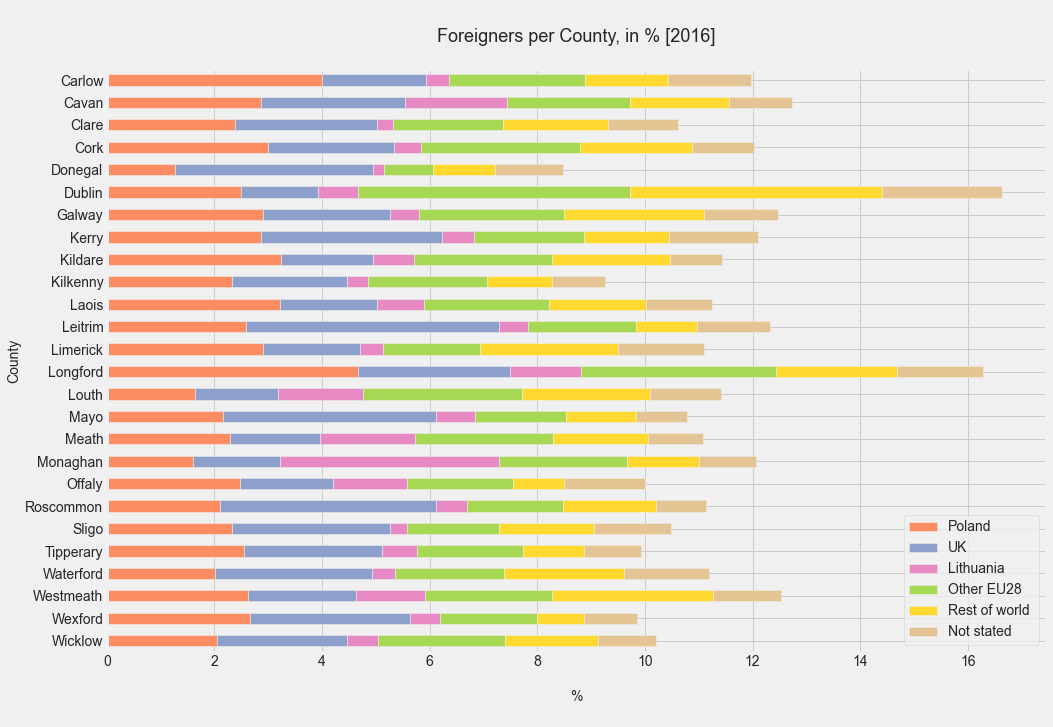

In [52]:
colors_nationalities = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
pre = df[nationalities_pre]
pre = pre.sort_index(ascending=False)
pre.columns = [n[:-1] for n in list(pre.columns)]

pre[['Poland', 'UK', 'Lithuania', 'Other EU28', 'Rest of world ','Not stated']].plot.barh(rot=0, figsize=(15,10), stacked= True, color=colors_nationalities[1:])
plt.title('\nForeigners per County, in % [2016]\n', fontsize=18)
plt.xlabel('\n%\n', fontsize=14)
plt.ylabel('County', fontsize=14)

plt.savefig('Minority_groups_county_pre', dpi=300, bbox_inches='tight')

plt.show()

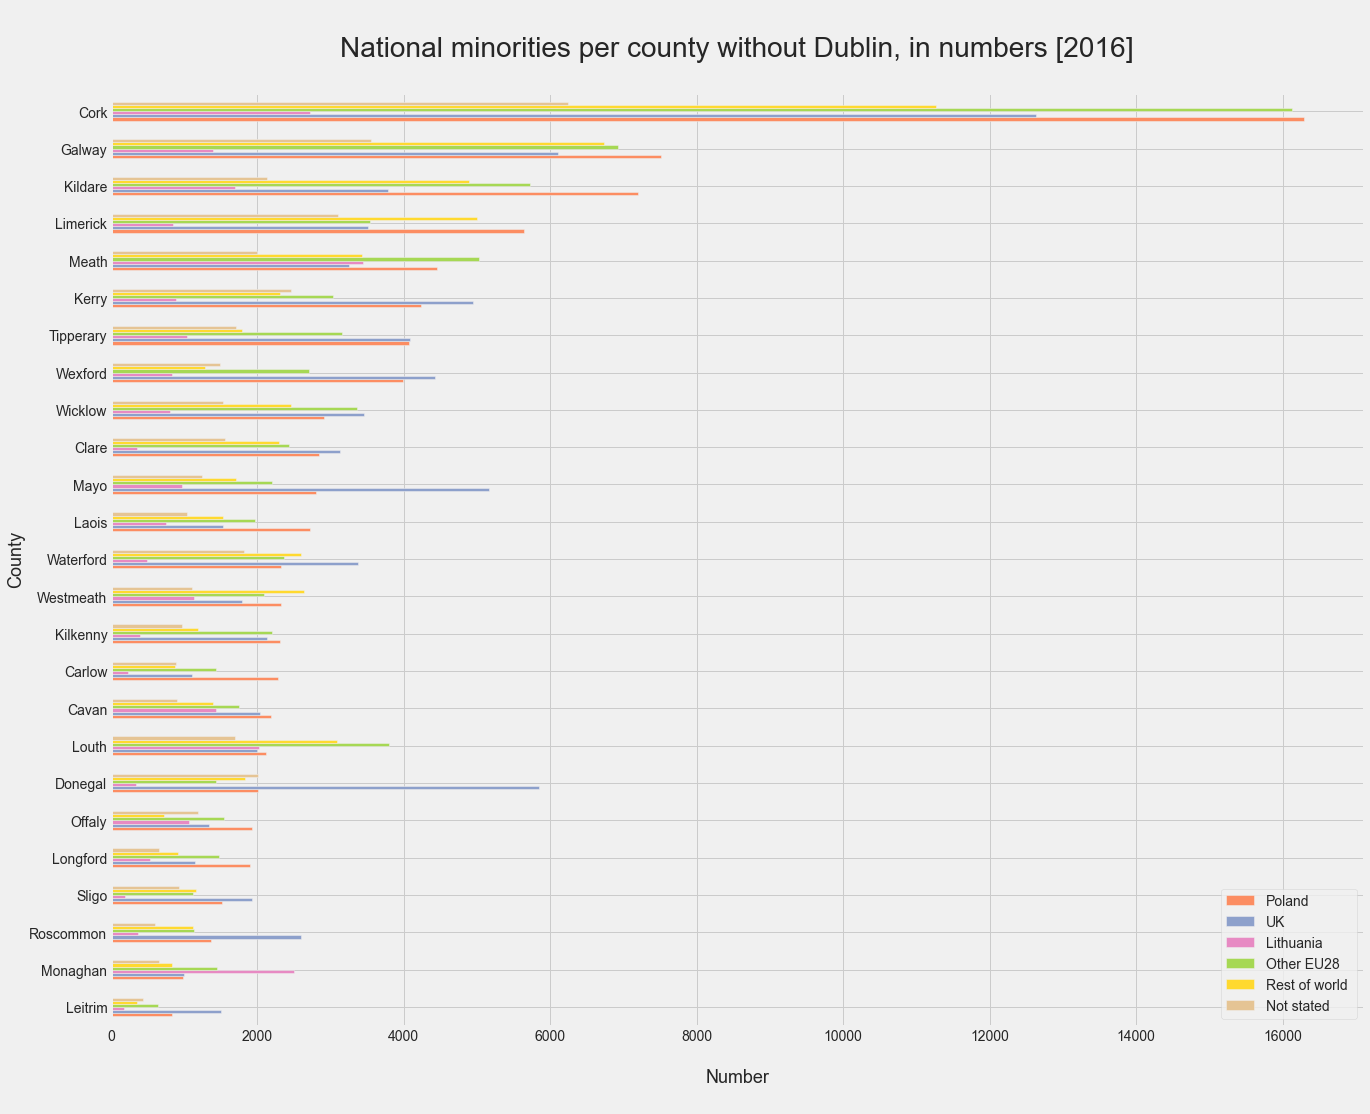

In [53]:
colors_nationalities = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
pre = df[nationalities]
pre = df.drop('Dublin' ) # exluding County Dublin from the chart
# pre = pre.sort_index(ascending=False)
pre=pre.sort_values(by=['Poland'], ascending=True)
pre[['Poland', 'UK', 'Lithuania', 'Other EU28', 'Rest of world ','Not stated']].plot.barh(rot=0, figsize=(20,16), color=colors_nationalities[1:])
plt.title('\nNational minorities per county without Dublin, in numbers [2016]\n ', fontsize=28)
plt.xlabel('\nNumber\n', fontsize=18)
plt.ylabel('County', fontsize=18)

plt.savefig('Minority_groups_county', dpi=300, bbox_inches='tight')

plt.show()

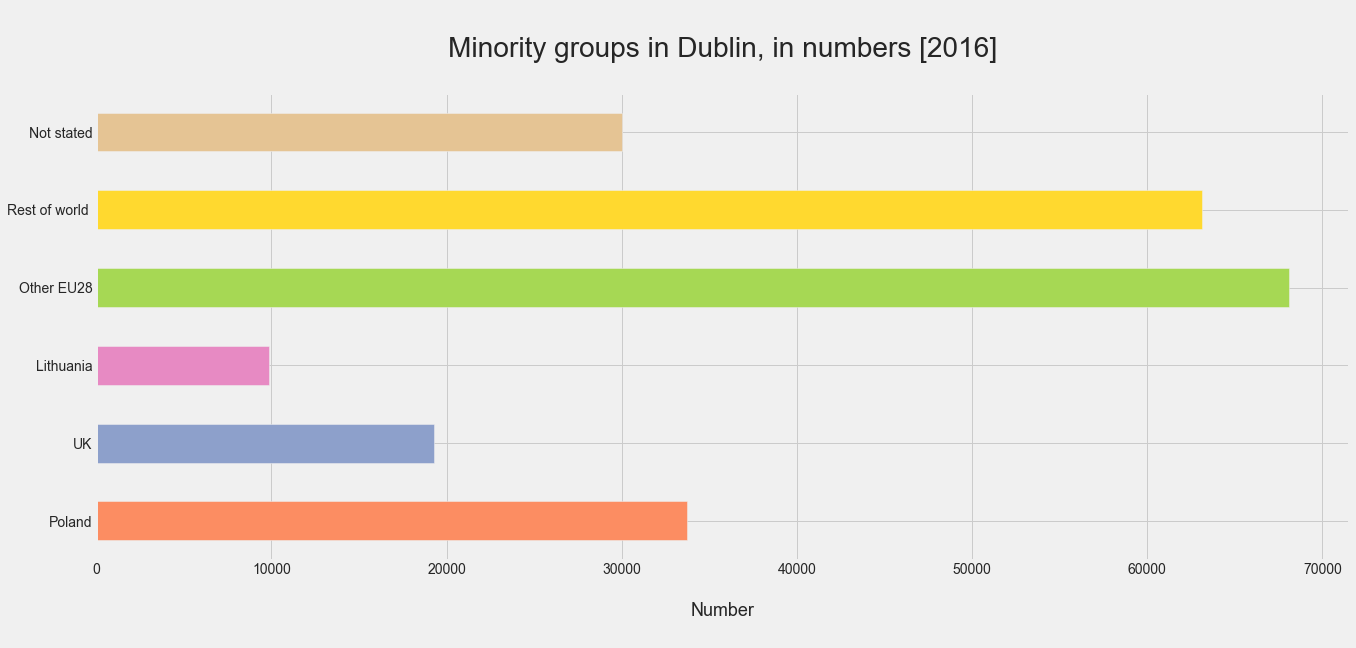

In [54]:
colors_nationalities = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
pre = df[nationalities]
pre = pre.loc['Dublin']
pre[['Poland', 'UK', 'Lithuania', 'Other EU28', 'Rest of world ','Not stated']].plot.barh(rot=0, figsize=(20,8), color=colors_nationalities[1:])
plt.title('\nMinority groups in Dublin, in numbers [2016]\n ', fontsize=28)
plt.xlabel('\nNumber\n', fontsize=18)

plt.savefig('Minority_groups_dublin_county', dpi=300, bbox_inches='tight')

plt.show()

### Electoral Divisions

In [55]:
print('Total number of electoral divisions in 2016: ', data.shape[0])

Total number of electoral divisions in 2016:  3409


In [56]:
data['Ireland%'] = ((data['Ireland']/data['Total Population']) * 100).round(2)
data['Poland%'] = ((data['Poland']/data['Total Population']) * 100).round(2)
data['Lithuania%'] = ((data['Lithuania']/data['Total Population']) * 100).round(2)
data['UK%'] = ((data['UK']/data['Total Population']) * 100).round(2)
data['Other EU28%'] = ((data['Other EU28']/data['Total Population']) * 100).round(2)
data['Rest of world%'] = ((data['Rest of world ']/data['Total Population']) * 100).round(2)

**Area** & **Population** of Counties

In [57]:
data['Density-p/km2'] = ( data['Total Population'] / data['area_km']).astype(int)

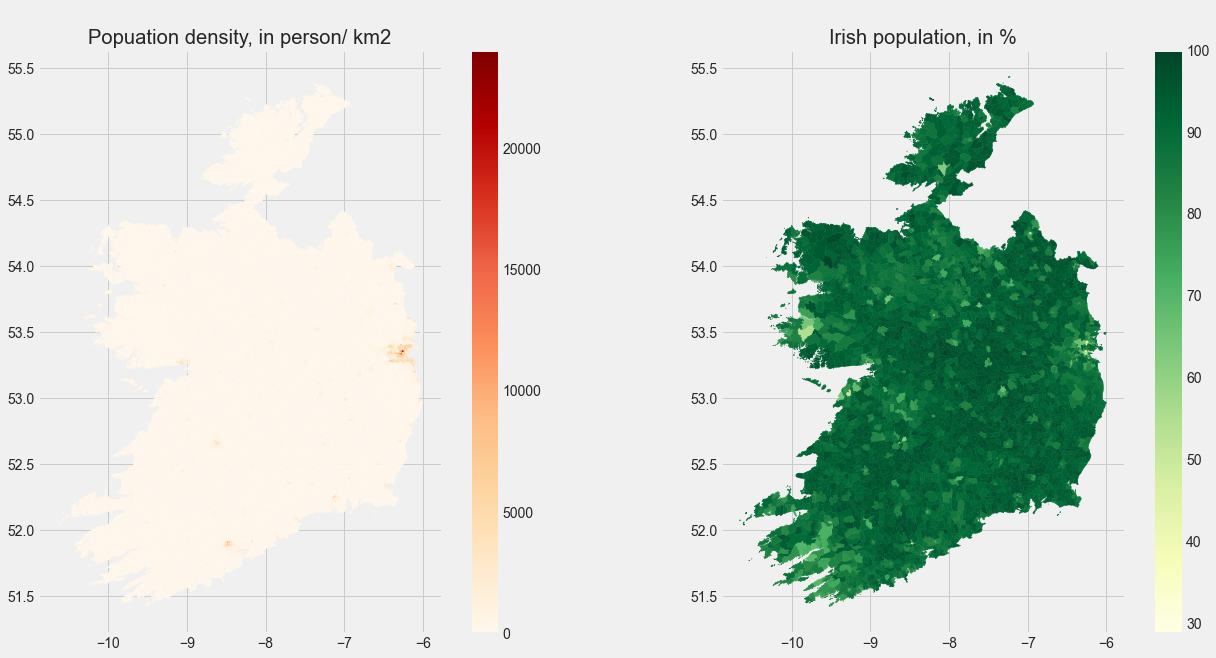

In [58]:
cmap = matplotlib.colors.ListedColormap(['#b3b3b3','#ff0000'])
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

data.plot(column='Density-p/km2', k=10, cmap='OrRd', legend=True, edgecolor="face", linewidth=0.4, ax=ax1)
data.plot(column='Ireland%', k=10, cmap='YlGn', legend=True, edgecolor="face", linewidth=0.4, ax=ax2)

ax1.title.set_text('\nPopuation density, in person/ km2')
ax2.title.set_text('\nIrish population, in %')

plt.savefig('IRISH_ED', dpi=300, bbox_inches='tight')

plt.show()

**Nationalities** in **Electoral Divisions**

**Basic stats** of the **Irish population** and the **biggest minorities** in Electoral Divisions

In [59]:
data[['Ireland%','Ireland','Poland%','Poland','UK%','UK','Lithuania%','Lithuania','Other EU28','Rest of world ','Not stated','Total Population']].describe()

,Ireland%,Ireland,Poland%,Poland,UK%,UK,Lithuania%,Lithuania,Other EU28,Rest of world,Not stated,Total Population
count,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000,3409.000000
mean,89.977996,1197.569082,1.186500,35.938692,2.941863,30.247287,0.351678,10.722206,43.044295,37.124377,21.100909,1396.850983
std,7.985701,1920.733320,1.956471,112.364744,2.204269,41.339118,0.872775,43.900141,123.049310,110.223106,55.538347,2329.295341
min,28.740000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000
25%,88.330000,321.000000,0.000000,0.000000,1.520000,9.000000,0.000000,0.000000,2.000000,1.000000,2.000000,349.000000
50%,92.300000,577.000000,0.480000,3.000000,2.350000,18.000000,0.000000,0.000000,6.000000,4.000000,5.000000,630.000000
75%,94.720000,1260.000000,1.400000,16.000000,3.690000,34.000000,0.400000,4.000000,22.000000,16.000000,15.000000,1443.000000
max,100.000000,30194.000000,25.190000,1590.000000,24.160000,442.000000,18.260000,1013.000000,3093.000000,1766.000000,875.000000,38894.000000


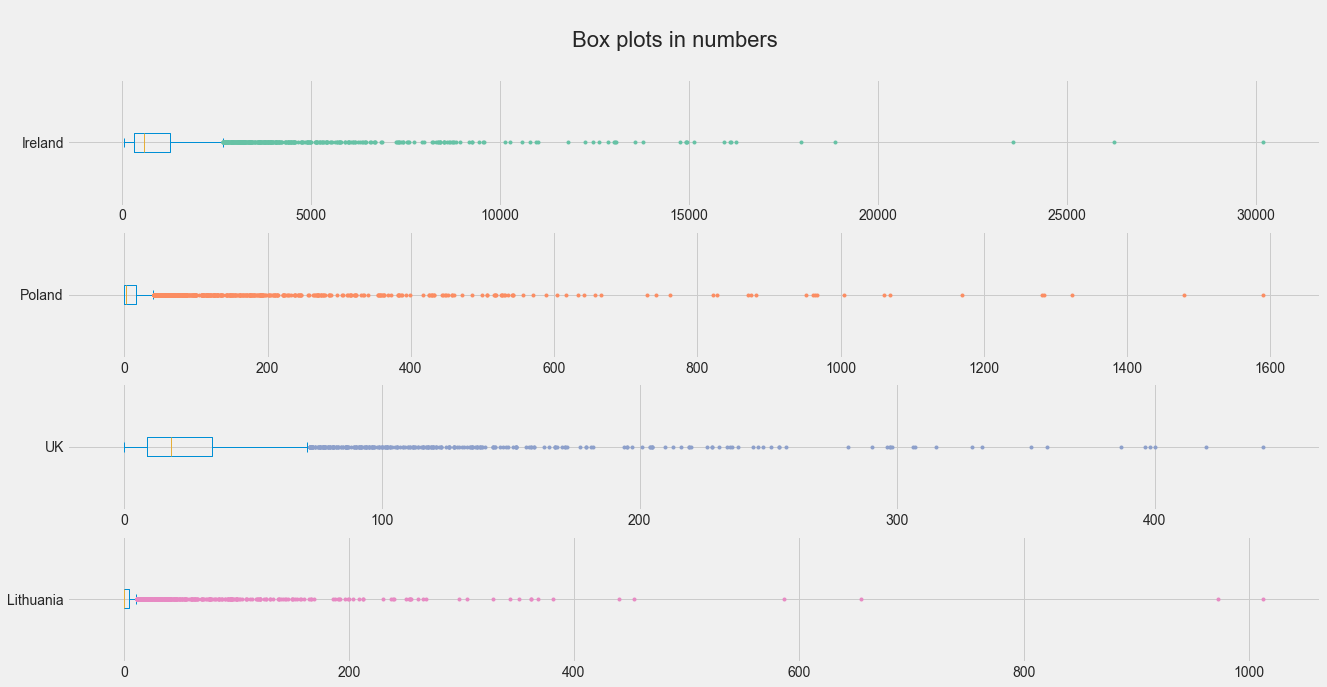

In [60]:
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])

box = dict(markerfacecolor='#66c2a5', markeredgecolor='#66c2a5', marker='.')
data['Ireland'].plot(kind='box', vert=False, flierprops=box, ax=ax1)

box = dict(markerfacecolor='#fc8d62', markeredgecolor='#fc8d62', marker='.')
data['Poland'].plot(kind='box', vert=False, flierprops=box, ax=ax2)

box = dict(markerfacecolor='#8da0cb', markeredgecolor='#8da0cb', marker='.')
data['UK'].plot(kind='box', vert=False, flierprops=box, ax=ax3)

box = dict(markerfacecolor='#e78ac3', markeredgecolor='#e78ac3', marker='.')
data['Lithuania'].plot(kind='box', vert=False, flierprops=box, ax=ax4)

fig.suptitle('\n Box plots in numbers', fontsize=22)

plt.savefig('BOX_PLOTS_ED', dpi=300, bbox_inches='tight')

plt.show()

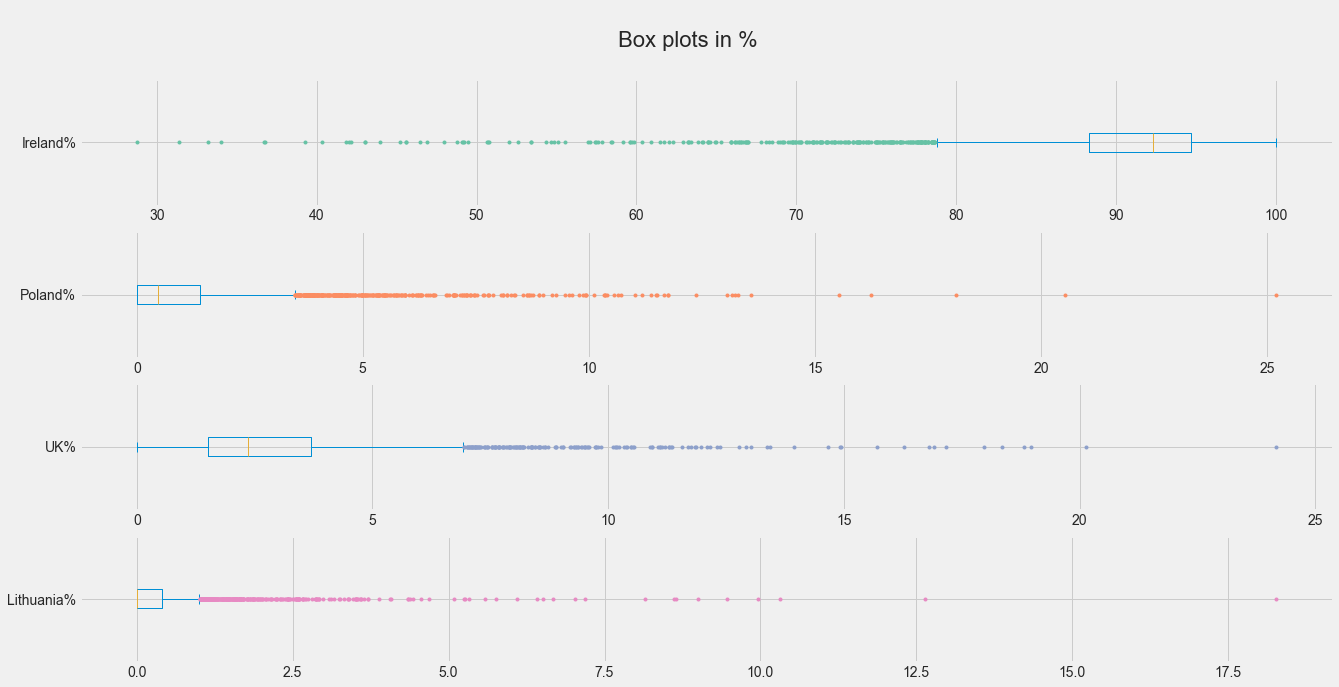

In [61]:
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])

box = dict(markerfacecolor='#66c2a5', markeredgecolor='#66c2a5', marker='.')
data['Ireland%'].plot(kind='box', vert=False, flierprops=box, ax=ax1)

box = dict(markerfacecolor='#fc8d62', markeredgecolor='#fc8d62', marker='.')
data['Poland%'].plot(kind='box', vert=False, flierprops=box, ax=ax2)

box = dict(markerfacecolor='#8da0cb', markeredgecolor='#8da0cb', marker='.')
data['UK%'].plot(kind='box', vert=False, flierprops=box, ax=ax3)

box = dict(markerfacecolor='#e78ac3', markeredgecolor='#e78ac3', marker='.')
data['Lithuania%'].plot(kind='box', vert=False, flierprops=box, ax=ax4)

fig.suptitle('\n Box plots in %', fontsize=22)

plt.savefig('BOX_PLOTS_PRE_ED', dpi=300, bbox_inches='tight')

plt.show()

**Top 10** Electoral divisions with the **highest percentage of Irish people**

In [62]:
data = data.sort_values(by=['Ireland%'], ascending=False)
data[['ED_ENGLISH', 'PROVINCE', 'COUNTY','Ireland%'] + nationalities].head(10)

,ED_ENGLISH,PROVINCE,COUNTY,Ireland%,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population
2718,BUNAVEELA,Connacht,Mayo,100.00,81,0,0,0,0,0,0,81
1003,MOORE,Connacht,Roscommon,99.35,306,0,0,0,0,0,1,308
1350,RATHNAVEOGE,Munster,Tipperary,99.24,260,0,1,0,1,0,0,262
1175,SCREGG,Connacht,Galway,99.13,227,0,1,0,1,0,0,229
3058,TULLA,Leinster,Offaly,99.08,108,0,1,0,0,0,0,109
1,KILBEACON,Leinster,Kilkenny,99.00,198,0,0,1,1,0,0,200
181,DRUMLOSH,Connacht,Roscommon,98.81,332,0,2,0,0,1,1,336
2309,TAGHEEN,Connacht,Mayo,98.81,166,0,1,0,0,1,0,168
1202,ROSSINVER WEST,Connacht,Sligo,98.75,237,2,1,0,0,0,0,240
832,DOON WEST,Munster,Limerick,98.73,234,2,0,0,1,0,0,237


**10** Electoral divisions with the **lowest percentage of Irish people**

In [63]:
data[['ED_ENGLISH', 'PROVINCE', 'COUNTY','Ireland%'] + nationalities].tail(10)

,ED_ENGLISH,PROVINCE,COUNTY,Ireland%,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population
1336,SHANDON B,Munster,Cork,42.04,589,88,25,11,301,145,82,1401
2,DOCK A,Munster,Limerick,41.86,979,269,117,34,217,522,123,2339
2057,ROTUNDA B,Leinster,Dublin,40.32,991,114,32,19,419,515,130,2458
2798,CENTRE A,Munster,Cork,39.29,341,45,18,6,156,74,23,868
983,MOUNTJOY B,Leinster,Dublin,36.79,1458,202,28,22,821,1239,126,3963
3067,ROTUNDA A,Leinster,Dublin,36.73,2191,154,97,42,928,1244,467,5965
2236,MANSION HOUSE B,Leinster,Dublin,34.02,446,4,39,1,96,126,99,1311
346,SHANNON A,Munster,Limerick,33.20,330,83,12,8,108,236,109,994
394,ROYAL EXCHANGE A,Leinster,Dublin,31.39,1359,38,113,8,412,610,472,4329
468,NORTH CITY,Leinster,Dublin,28.74,1625,125,65,17,893,1435,654,5654


In [64]:
data = data.sort_values(by=['Poland'], ascending=False)
data['ED_ENGLISH'] = data['ED_ENGLISH'].str.title()

data['top10number'] = 'NO'# assigning no to all EDs
rows = data[['ED_ENGLISH', 'PROVINCE', 'COUNTY'] + nationalities].head(10).index #assigning yes to top 10
data.loc[rows, 'top10number'] = 'YES'

**Top 10** Electoral divisions with the **highest number of Polish people**

In [75]:
data[['ED_ENGLISH', 'PROVINCE', 'COUNTY'] + nationalities].head(10)

,ED_ENGLISH,PROVINCE,COUNTY,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population
1573,Rosbercon Urban,Leinster,Wexford,376,162,18,28,27,20,7,643
2504,Custom House,Munster,Limerick,342,151,19,3,56,96,48,736
2486,Dock B,Munster,Limerick,615,195,30,9,64,107,51,1077
3020,Granard Urban,Leinster,Longford,796,178,13,7,72,10,17,1096
524,Market,Munster,Limerick,1001,316,44,29,200,362,71,2035
3156,Ballyconnell,Ulster,Cavan,1110,211,45,53,87,19,10,1553
184,Borris,Leinster,Laois,1118,224,13,59,164,76,26,1686
3408,Timoleague,Munster,Cork,558,98,40,0,11,4,1,740
270,New Ross Rural,Leinster,Wexford,3066,519,61,108,58,37,76,3942
1304,Dubber,Leinster,Dublin,4789,962,47,187,483,574,290,7372


**Top 10** places with the **highest percentage of Polish people**

In [74]:
data = data.sort_values(by=['Poland%'], ascending=False)
data['top10pre'] = 'NO'# assigning no to all EDs
rows = data[['ED_ENGLISH', 'PROVINCE', 'COUNTY'] + nationalities].head(10).index #assigning yes to top 10
data.loc[rows, 'top10pre'] = 'YES'
data[['ED_ENGLISH', 'PROVINCE', 'COUNTY'] + nationalities + ['Poland%']].head(10)

,ED_ENGLISH,PROVINCE,COUNTY,Ireland,Poland,UK,Lithuania,Other EU28,Rest of world,Not stated,Total Population,Poland%
1573,Rosbercon Urban,Leinster,Wexford,376,162,18,28,27,20,7,643,25.19
2504,Custom House,Munster,Limerick,342,151,19,3,56,96,48,736,20.52
2486,Dock B,Munster,Limerick,615,195,30,9,64,107,51,1077,18.11
3020,Granard Urban,Leinster,Longford,796,178,13,7,72,10,17,1096,16.24
524,Market,Munster,Limerick,1001,316,44,29,200,362,71,2035,15.53
3156,Ballyconnell,Ulster,Cavan,1110,211,45,53,87,19,10,1553,13.59
184,Borris,Leinster,Laois,1118,224,13,59,164,76,26,1686,13.29
3408,Timoleague,Munster,Cork,558,98,40,0,11,4,1,740,13.24
270,New Ross Rural,Leinster,Wexford,3066,519,61,108,58,37,76,3942,13.17
1304,Dubber,Leinster,Dublin,4789,962,47,187,483,574,290,7372,13.05


**Number of Electoral Division without Polish people**

In [ ]:
(data['Poland'] == 0).astype(int).sum()

In [ ]:
data['PLPopulation'] = np.where((data['Poland'] == 0), 'NO', 'YES')

In [ ]:
cmap = matplotlib.colors.ListedColormap(['#b3b3b3','#fc8d62'])
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(1,3)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

data.plot(column='top10number', edgecolor="face", linewidth=0.4, cmap=cmap, ax=ax1)
data.plot(column='top10pre', edgecolor="face", linewidth=0.4, cmap=cmap, ax=ax2)
data.plot(column='PLPopulation', edgecolor="face", linewidth=0.4, cmap=cmap, legend=True, ax=ax3)

ax1.title.set_text('\nTop 10 Electoral divisions\nwith highest number of Polish People')
ax2.title.set_text('\nTop 10 Electoral divisions\nwith highest % of Polish Population')
ax3.title.set_text('\nElectoral divisions\nwith Polish Population ')

plt.savefig('Polish_TOP_WHERE_ED', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# selecting only eds with polish population
df = data[data['Poland'] > 0]

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

data.plot(column='Poland', k=10, cmap='Reds', legend=True, edgecolor="face", linewidth=0.4, ax=ax1)
data.plot(column='Poland%', k=10, cmap='Reds', legend=True, edgecolor="face", linewidth=0.4, ax=ax2)

ax1.title.set_text('\nPolish population, in numbers')
ax2.title.set_text('\nPolish population, in %')

plt.savefig('Polish_ED', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

data.plot(column='Lithuania', k=10, cmap='RdPu', legend=True, edgecolor="face", linewidth=0.4, ax=ax1)
data.plot(column='Lithuania%', k=10, cmap='RdPu', legend=True, edgecolor="face", linewidth=0.4, ax=ax2)

ax1.title.set_text('\nLithuanian population, in numbers')
ax2.title.set_text('\nLithuanian population, in %')

plt.savefig('Lithuanian_ED', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

data.plot(column='UK', k=10, cmap='Blues', legend=True, edgecolor="face", linewidth=0.4, ax=ax1)
data.plot(column='UK%', k=10, cmap='Blues', legend=True, edgecolor="face", linewidth=0.4, ax=ax2)

ax1.title.set_text('\nUK population, in numbers')
ax2.title.set_text('\nUK population, in %')

plt.savefig('English_ED')

plt.show()

In [ ]:
color_map = plt.cm.get_cmap('summer')
reversed_color_map = color_map.reversed()

fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

data.plot(column='Other EU28', k=10, cmap='summer', legend=True, edgecolor="face", linewidth=0.4, ax=ax1)
data.plot(column='Other EU28%', k=10, cmap='summer', legend=True, edgecolor="face", linewidth=0.4, ax=ax2)

ax1.title.set_text('\nOther EU28 population, in numbers')
ax2.title.set_text('\nOther EU28 population, in %')

plt.savefig('Other_EU28_ED', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

data.plot(column='Rest of world ', k=10, cmap='Wistia', legend=True, edgecolor="face", linewidth=0.4, ax=ax1)
data.plot(column='Rest of world%', k=10, cmap='Wistia', legend=True, edgecolor="face", linewidth=0.4, ax=ax2)

ax1.title.set_text('\nRest of world population, in numbers')
ax2.title.set_text('\nRest of world population, in %')

plt.savefig('Rest_of_world_ED', dpi=300, bbox_inches='tight')

plt.show()

T2_1IEN
T2_1PLN
T2_1UKN
T2_1LTN
T2_1EUN
T2_1RWN
T2_1NSN
T1_1AGETT

- T2_1PLN -- Poland - Nationality
- T2_1PLBP -- Poland - Birthplace
- T1_1AGETT -- Total Population 
- T2_1IEN -- Ireland - Nationality
- T2_1UKN -- UK - Nationality
- T2_1LTN -- Lithuania - Nationality
- T2_1EUN -- Other EU28 - Nationality
- T2_1RWN -- Rest of world - Nationality
- T2_1NSN -- Not stated - Nationality

Covered topics:
- reading shapefile using geopandas
- CRS and reprojection of the geodataframes
- creating a new geodataframe from plain coordinates
- ploting point and polygon geometries on the map
- visualizing categorical data using: waffle charts, Treemap,

INTRESTING FINDINGS:
- Waffels to display data
    - https://towardsdatascience.com/comparing-different-ways-of-displaying-categorical-data-in-python-ed8fabfb6661
    - https://towardsdatascience.com/best-ways-to-visualize-proportions-956218c7d164
    - https://stackoverflow.com/questions/41400136/how-to-do-waffle-charts-in-python-square-piechart

- Choropleth classification schemes from PySAL for use with GeoPandas 
    - https://geopandas.org/en/stable/gallery/choropleths.html